# Plotting Memory Suppression Experiments on Top of Each Other

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime
from core import Config
import pickle

In [ ]:
def plot_haystack_train_conv_mem_supress(only_beg, colors, fin_quartiles_ckpts, beg_quartiles_ckpts, x_values_list, valA, haystack_len, experiments, steps, nope, abs_err=False):
    fig_sz_boost = 1.5
    marker_boost = 2
    fig, ax = plt.subplots(1, 1, sharex=True, figsize=(fig_sz_boost*6, fig_sz_boost*4.7))
    fig_len, ax_len = plt.subplots(1, 1, sharex=True, figsize=(fig_sz_boost*6, fig_sz_boost*4.7))

    early_stop_ind = None

    # if valA == "ortho":
    #     steps = [1,2,3,5,10]
    # else:
    #     steps = [1,2,3]

    if len(steps) > len(colors):
        # generate more colors from viridis colormap
        colors = plt.cm.viridis(np.linspace(0, 1, len(steps)))

    print(f"\n\n in haystack train conv plot valA: {valA}, abs_err: {abs_err}\n\n")

    exp_count = 0
    for fin_quartiles_ckpt, beg_quartiles_ckpt, x_values in zip(fin_quartiles_ckpts, beg_quartiles_ckpts, x_values_list):
        for key in fin_quartiles_ckpt.keys():
            if key == "MOP": #key == "OLS_analytical_ir_1" or key == "OLS_ir_1": #key == "MOP" or 
                col_count = 0
                for step in steps:

                    key_lab = "TF" if key == "MOP" else key
                    qs = np.array(fin_quartiles_ckpt[key][step])
                    qs = np.transpose(qs)

                    if valA == "gaussA":
                        if not abs_err:
                            qs -= 1

                    # #if key contains OLS then repeat the values in qs to be the length of x_values
                    # if "OLS" in key:
                    #     print(f"key: {key} qs shape: {qs.shape}")
                    #     qs = np.repeat(qs, len(x_values), axis=0)
                    #     print(f"qs shape after repeat: {qs.shape}")

                    if step == 2:
                        #find the index of the minimum of qs[1]
                        early_stop_ind = np.argmin(qs[1])
                        print(f"early_stop_ind: {early_stop_ind}, x_values[early_stop_ind]: {x_values[early_stop_ind]}")

                        # raise NotImplementedError("Check the early stop index")
                    
                    if not only_beg:
                        ax.plot(x_values, qs[1], label=f"{key_lab}: {step} after final {experiments[exp_count]}", markersize=marker_boost*5, marker="." if exp_count == 0 else ">", zorder=5 if key == "MOP" else 0, color=colors[col_count], linewidth=2)
                        # if not valA == "gaussA":
                        #     ax.fill_between(x_values, qs[0], qs[2], alpha=0.2, color=colors[col_count])

                        ax.fill_between(x_values, qs[0], qs[2], alpha=0.2, color=colors[col_count])

                        ax_len.plot(x_values, qs[1], label=f"{key_lab}: {step} after final {experiments[exp_count]}", markersize=marker_boost*5, marker="." if exp_count == 0 else ">", zorder=5 if key == "MOP" else 0, color=colors[col_count], linewidth=2)
                        ax_len.fill_between(x_values, qs[0], qs[2], alpha=0.2, color=colors[col_count])


                        color = ax.get_lines()[-1].get_color()

                    else:
                        color = colors[col_count]

                    beg_qs = np.array(beg_quartiles_ckpt[key][step])
                    beg_qs = np.transpose(beg_qs)
                    #set the color to the same as the fin quartiles
                    ax.plot(x_values, beg_qs[1], label=f"{key_lab}: {step} after initial {experiments[exp_count]}", markersize=1 if "OLS" in key_lab else marker_boost*5, marker="x" if exp_count == 0 else "<", color=color, linestyle="-" if "OLS_ir" in key_lab else (":" if "OLS_analytical" in key_lab else "--"), linewidth=5 if "OLS_analytical" in key_lab else 2)

                    # if not valA == "gaussA":
                    #     ax.fill_between(x_values, beg_qs[0], beg_qs[2], alpha=0.2, color=color)
                    ax.fill_between(x_values, beg_qs[0], beg_qs[2], alpha=0.2, color=color)

                    ax_len.plot(x_values, beg_qs[1], label=f"{key_lab}: {step} after initial {experiments[exp_count]}", markersize=1 if "OLS" in key_lab else marker_boost*5, marker="x" if exp_count == 0 else "<", color=color, linestyle="-" if "OLS_ir" in key_lab else (":" if "OLS_analytical" in key_lab else "--"), linewidth=5 if "OLS_analytical" in key_lab else 2)
                    ax_len.fill_between(x_values, beg_qs[0], beg_qs[2], alpha=0.2, color=color)

                    col_count += 1
        exp_count += 1

    # plt.tight_layout()
    # plt.subplots_adjust(left=0.15, right=0.95, top=0.95, bottom=0.15)  # Adjust margins as needed

    ax.set_xlabel("# of Training Examples", fontsize=14)
    ax.set_ylabel(f"Error " + ("Ratio" if valA == "gaussA" and not abs_err else ""), fontsize=14)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.grid(True, which="both")
    # ax.legend(fontsize=8, bbox_to_anchor=(1.05, 1))
    fig.legend(fontsize=8, loc="outside lower left", ncol=3, bbox_to_anchor=(0.1, 0.1))
    ax.set_xlim(x_values[0] - 1e3, x_values[-1] + 1e3)
    # ax.set_ylim([5e-2, 3e0])
    # ax.set_title(("Ortho" if valA == "ortho" else ("Gaussian" if valA == "gaussA" else "Identity")) + f" Haystack Length: {haystack_len} vs Training Examples")

    ax_len.set_xlabel("# of Training Examples", fontsize=14)
    ax_len.set_ylabel(f"Error " + ("Ratio" if valA == "gaussA" and not abs_err else ""), fontsize=14)
    ax_len.set_yscale('linear')
    ax_len.set_xscale('log')
    ax_len.grid(True, which="both")
    # ax_len.legend(fontsize=8) #"center right" if valA == "ident" else 
    fig_len.legend(fontsize=8, loc="outside lower left", ncol=3, bbox_to_anchor=(0.1, 0.1))
    ax_len.set_xlim(x_values[0] - 1e3, x_values[-1] + 1e3)


    #add the date and time to the filename
    now = datetime.now()
    timestamp = now.strftime("%Y%m%d_%H%M%S")


    figure_dir = f"../outputs/mem_suppress_conglomerate/" 
    os.makedirs(figure_dir, exist_ok=True)

    fig.tight_layout()
    fig_len.tight_layout()
    
    fig.savefig(figure_dir + f"mem_suppress_conglomerate_{valA}_embd_dim_192_train_conv_haystack_len_{haystack_len}_{timestamp}_logscale.pdf", transparent=True, format="pdf")
    
    fig_len.savefig(figure_dir + f"mem_suppress_conglomerate_{valA}_embd_dim_192_train_conv_haystack_len_{haystack_len}_{timestamp}_linearscale.pdf", transparent=True, format="pdf")

    plt.show()
    return early_stop_ind

In [6]:
only_beg = False
colors=['#000000', '#005CAB', '#E31B23', '#FFC325', '#00A651', '#9B59B6']

hay_len = 1

train_conv_beg_quartiles_files = [f"/home/sultand/TFs_do_KF_ICL/outputs/GPT2/250501_221900.f583e5_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.4766370475008905e-05_num_train_sys_40000/needles/train_conv/train_conv_beg_quartiles_haystack_len_{hay_len}.pkl", f"/home/sultand/TFs_do_KF_ICL/outputs/GPT2/backstory_masked_250501_221900.f583e5_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.4766370475008905e-05_num_train_sys_40000/needles/train_conv/train_conv_beg_quartiles_haystack_len_{hay_len}.pkl"]

train_conv_fin_quartiles_files = [f"/home/sultand/TFs_do_KF_ICL/outputs/GPT2/250501_221900.f583e5_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.4766370475008905e-05_num_train_sys_40000/needles/train_conv/train_conv_fin_quartiles_haystack_len_{hay_len}.pkl", f"/home/sultand/TFs_do_KF_ICL/outputs/GPT2/backstory_masked_250501_221900.f583e5_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.4766370475008905e-05_num_train_sys_40000/needles/train_conv/train_conv_fin_quartiles_haystack_len_{hay_len}.pkl"]

x_values_files = [f"/home/sultand/TFs_do_KF_ICL/outputs/GPT2/250501_221900.f583e5_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.4766370475008905e-05_num_train_sys_40000/needles/train_conv/x_values_haystack_len_{hay_len}.npy", f"/home/sultand/TFs_do_KF_ICL/outputs/GPT2/backstory_masked_250501_221900.f583e5_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.4766370475008905e-05_num_train_sys_40000/needles/train_conv/x_values_haystack_len_{hay_len}.npy"]

beg_quartiles_ckpts = []
fin_quartiles_ckpts = []
x_values_list = []
for train_conv_beg_quartiles_file, train_conv_fin_quartiles_file, x_values_file in zip(train_conv_beg_quartiles_files, train_conv_fin_quartiles_files, x_values_files):
    if os.path.exists(train_conv_beg_quartiles_file):
        print(f"Loading train conv beg quartiles from {train_conv_beg_quartiles_file}")
        with open(train_conv_beg_quartiles_file, "rb") as f:
            beg_quartiles_ckpt = pickle.load(f)
            beg_quartiles_ckpts.append(beg_quartiles_ckpt)

    if os.path.exists(train_conv_fin_quartiles_file):
        print(f"Loading train conv fin quartiles from {train_conv_fin_quartiles_file}")
        with open(train_conv_fin_quartiles_file, "rb") as f:
            fin_quartiles_ckpt = pickle.load(f)
            fin_quartiles_ckpts.append(fin_quartiles_ckpt)

    if os.path.exists(x_values_file):
        print(f"Loading x values from {x_values_file}")
        x_values = np.load(x_values_file)
        x_values_list.append(x_values)

    



Loading train conv beg quartiles from /home/sultand/TFs_do_KF_ICL/outputs/GPT2/250501_221900.f583e5_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.4766370475008905e-05_num_train_sys_40000/needles/train_conv/train_conv_beg_quartiles_haystack_len_1.pkl
Loading train conv fin quartiles from /home/sultand/TFs_do_KF_ICL/outputs/GPT2/250501_221900.f583e5_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.4766370475008905e-05_num_train_sys_40000/needles/train_conv/train_conv_fin_quartiles_haystack_len_1.pkl
Loading x values from /home/sultand/TFs_do_KF_ICL/outputs/GPT2/250501_221900.f583e5_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.4766370475008905e-05_num_train_sys_40000/needles/train_conv/x_values_haystack_len_1.npy
Loading train conv beg quartiles from /home/sultand/TFs_do_KF_ICL/outputs/GPT2/backstory_masked_250501_221900.f583e5_multi_sys_trace_ortho_haar_state_dim_5_ident_C_lr_1.4766370475008905e-05_num_train_sys_40000/needles/train_conv/train_conv_beg_quartiles_haystack_l



 in haystack train conv plot valA: ortho_haar, abs_err: False


early_stop_ind: 37, x_values[early_stop_ind]: 78080000
early_stop_ind: 9, x_values[early_stop_ind]: 38400000


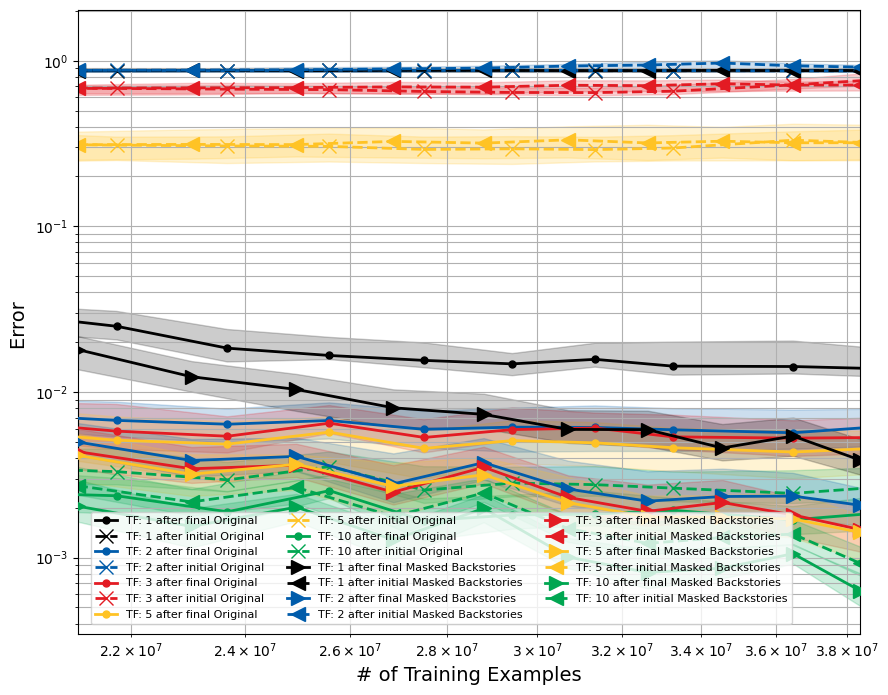

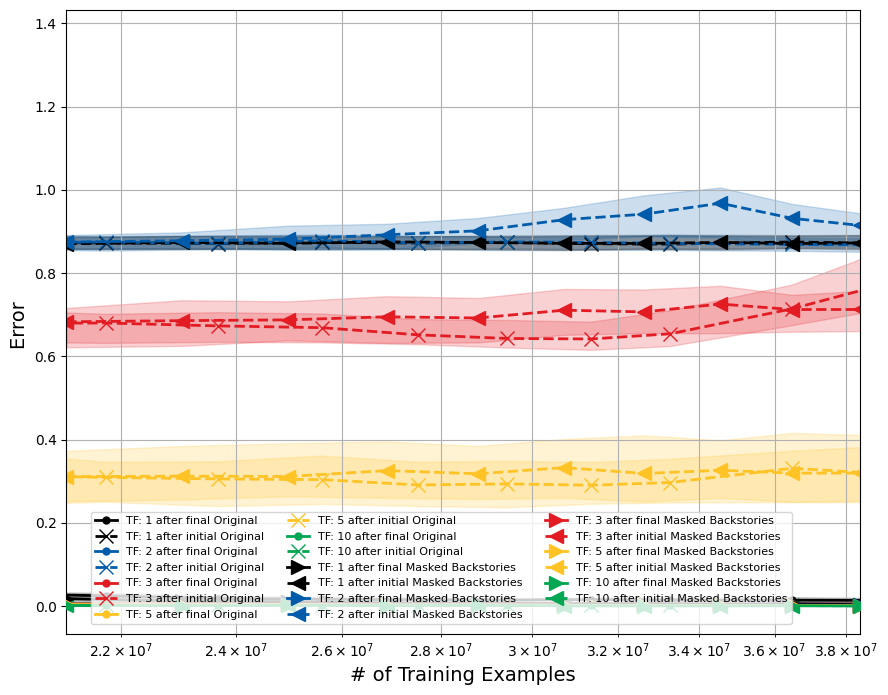

np.int64(9)

In [31]:
plot_haystack_train_conv_mem_supress(only_beg, colors, fin_quartiles_ckpts, beg_quartiles_ckpts, x_values_list, "ortho_haar", hay_len, ["Original", "Masked Backstories"], steps=[1,2,3,5,10], nope=False, abs_err=False)